In [929]:
import pickle
import os
import tweepy
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import json
from nltk.stem.porter import PorterStemmer
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import unicodedata
import folium
from folium import plugins
import requests

## Access Twitter API with Tweepy

In [2]:
if not os.path.exists('twitter_creds.pk1'):
    Twitter={}
    Twitter['Consumer Key'] = ""
    Twitter['Consumer Secret'] = ""
    Twitter['Access Token'] = ""
    Twitter['Access Token Secret'] = ""
    with open('twitter_creds.pk1','wb') as f:
        pickle.dump(Twitter,f)
else:
    Twitter = pickle.load(open('twitter_creds.pk1','rb'))

In [3]:
c_k = Twitter["Consumer Key"]
c_s = Twitter["Consumer Secret"]

a_t = Twitter["Access Token"]
a_s = Twitter["Access Token Secret"]

auth = tweepy.OAuthHandler(c_k, c_s)
auth.set_access_token(a_t, a_s)
api = tweepy.API(auth, wait_on_rate_limit=True)

Function to get tweets given a query, a geocode location, and an upper limit

In [4]:
def get_tweets(q,geo,num):
    search_results = tweepy.Cursor(api.search_tweets, q=q, geocode=geo, lang="en").items(num)

    tweets = []

    for tweet in search_results:
        try:
            status = api.get_status(tweet.id, tweet_mode = "extended")
        except:
            status = api.get_status(tweet.id, tweet_mode = "extended")
        else:
            tweets.append(status.full_text)

    return pd.DataFrame({'message':tweets, "location":geo})

Test function for 5km radius around LA

In [18]:
q = ['global warming OR globalwarming OR climate change OR climatechange']
number = 10
#Los Angeles, CA
geo="34.03657,-118.29661,5km"

test_df = get_tweets(q,geo,number)
test_df

,message,location
0,@LeftReckoning 6/6 …our climate. At this point...,"34.03657,-118.29661,5km"
1,“Climate change is one of the most profound in...,"34.03657,-118.29661,5km"
2,Global Warming is Causing Climate Change and M...,"34.03657,-118.29661,5km"
3,Ezra Klein is a brilliant essayist but even he...,"34.03657,-118.29661,5km"
4,@BigJonah68 When the royals feel they are losi...,"34.03657,-118.29661,5km"
5,There is #OnlyOneEarth. Protecting it is every...,"34.03657,-118.29661,5km"
6,Global Warming is Causing Climate Change and M...,"34.03657,-118.29661,5km"
7,@alkivari @BreezyScroll The scientist in the a...,"34.03657,-118.29661,5km"
8,70% of carbon emissions are by 100 companies. ...,"34.03657,-118.29661,5km"
9,Global Warming is Causing Climate Change and M...,"34.03657,-118.29661,5km"


# Cleaning Data

### Tokenize and stem the tweet, eliminating useless words

In [5]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/avandstefan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/avandstefan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation) + ['https','http']

In [7]:
stemmer = PorterStemmer()

In [8]:
def tokenize_and_stem(df, stemmer):
    tweets = df['message']
    clean = []
    for tweet in tweets:
        t = tweet.encode('ascii','ignore').decode('ascii')
        t = re.sub(r'http\S+','',t).lower()
        tokenized = list(set(nltk.word_tokenize(t)).difference(useless_words))
        out = []
        for word in tokenized:
            out.append(stemmer.stem(word))
        clean.append(' '.join(str(word) for word in out))
    df['clean'] = clean
    return df

## Clean Training Data

In [51]:
#sentiment of -1 is negative, 0 is neutral, 1 is positive, 2 is a fact
train = pd.read_csv('twitter_sentiment_data.csv')
train_2 = pd.read_csv('more_training.csv')
train = pd.concat([train,train_2])

In [52]:
train = tokenize_and_stem(train, stemmer)
train

,sentiment,message,tweetid,clean
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,planet stop warm suv boom hustl ye 15 global c...
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641,beforetheflood rt htt climat world right chang...
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,'s film fabul youtub climat via dicaprio leona...
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904,mick_fan rt watch think amaz documentari leona...
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153,cnaliv give pranita rt odisha amp biswasi chan...
...,...,...,...,...
49,0,"""There's very little climate change appearing ...",1,'s appear writer support evolv `` better resou...
50,-1,Global Warming and Gun control is such a scam!...,1,global warm scam righttobeararm gun make sens ...
51,-1,"@dan_florie ""It's colder than normal. Global w...",1,'s warm dan_flori `` real colder global ca nor...
52,0,wtf the mona lisa gotta do with climate change,1,chang got ta lisa mona climat wtf


## Train Model

In [64]:
vectorizer = CountVectorizer(stop_words="english")
vectorizer.fit(train['clean'])
X = vectorizer.transform(train['clean'])

x_train,x_test,y_train,y_test = train_test_split(X,train['sentiment'], random_state = 20, test_size = 0.2)

In [918]:
model = LogisticRegression(multi_class='multinomial',solver='lbfgs', max_iter=1000)
model.fit(x_train,y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [919]:
pred = model.predict(x_test)
accuracy_score(y_test,pred)

0.7340909090909091

Ensure nothing went wrong by predicting the training data

In [920]:
pred_train = model.predict(x_train)
accuracy_score(y_train,pred_train)

0.9211012302184846

## Query Twitter for actual data

Get a list of the top 200 cities and their geolocations. This makes up for ~25% of the US population

In [219]:
cities = pd.read_csv('uscities.csv')

In [234]:
feats = ['city','state_id','lat','lng','population']
cities = cities[feats]
cities.drop(cities[cities['state_id'] == 'PR'].index,inplace=True)

In [235]:
cities = cities.sort_values(by=['state_id','population'], ascending=False)

In [236]:
#5 most populated cities in each state
cities = cities.groupby('state_id').head(10)

In [237]:
#function that returns a geolocation string
def get_geo(a,rad):
    return format(a.lat, ".5f") + ',' + format(a.lng, ".5f") + ',' + rad

In [238]:
rad = '10km'
cities['geo'] = cities.apply(get_geo, rad = rad, axis = 1)
cities

,city,state_id,lat,lng,population,geo
625,Cheyenne,WY,41.1350,-104.7902,76456,"41.13500,-104.79020,10km"
781,Casper,WY,42.8420,-106.3208,63962,"42.84200,-106.32080,10km"
1399,Laramie,WY,41.3099,-105.6085,32515,"41.30990,-105.60850,10km"
1400,Gillette,WY,44.2752,-105.4982,32513,"44.27520,-105.49820,10km"
1936,Rock Springs,WY,41.5947,-109.2209,23238,"41.59470,-109.22090,10km"
...,...,...,...,...,...,...
3281,College,AK,64.8694,-147.8216,12734,"64.86940,-147.82160,10km"
3844,Wasilla,AK,61.5770,-149.4660,10469,"61.57700,-149.46600,10km"
3853,Tanaina,AK,61.6576,-149.4263,10449,"61.65760,-149.42630,10km"
4213,North Lakes,AK,61.6191,-149.3110,9321,"61.61910,-149.31100,10km"


In [249]:
#gets a maximum of 1000 tweets within a 10km radius of the top 10 cities from each state
results = []
counter = 0
max_num = 1000
q = ['"global warming" OR globalwarming OR "climate change" OR climatechange']
for geo in cities.geo:
    results.append(get_tweets(q,geo,max_num))
    counter = counter + 1
    print(counter)

data = pd.concat(results)
data

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


Rate limit reached. Sleeping for: 77


27
28
29
30
31


Rate limit reached. Sleeping for: 591


32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77


Rate limit reached. Sleeping for: 548


78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146


Rate limit reached. Sleeping for: 571


147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166


Rate limit reached. Sleeping for: 557


167
168
169
170
171
172
173
174
175
176


Rate limit reached. Sleeping for: 562


177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217


,message,location
0,It’ll only get hotter as we continue to burn f...,"42.27590,-83.73100,10km"
1,"@Jim_Jordan From Jim, the intellectual giant i...","42.27590,-83.73100,10km"
2,@ianmac55 @CyclingSurrey @ianwalker @SaskiaHei...,"42.27590,-83.73100,10km"
3,Condensing water from the atmosphere will be o...,"42.27590,-83.73100,10km"
4,23 percent more Indians at risk of hunger by 2...,"42.27590,-83.73100,10km"
...,...,...
1,More areas of year-round unfrozen ground have ...,"64.86940,-147.82160,10km"
0,@kathys73701307 @JesusECast It's nice to PRETE...,"61.57700,-149.46600,10km"
1,@RobertC26440604 @FoxNews I agree what they di...,"61.57700,-149.46600,10km"
0,@kathys73701307 @JesusECast It's nice to PRETE...,"61.65760,-149.42630,10km"


In [244]:
results_first_set = results

In [245]:
first = pd.concat(results_first_set)
first

,message,location
0,@CarCarley2 @HandInfinity @villagrippa Not bac...,"41.13500,-104.79020,10km"
0,“Our landscape has been shaped by climate chan...,"42.84200,-106.32080,10km"
1,About 17% of the U.S. population relies on pri...,"42.84200,-106.32080,10km"
2,The impacts of climate-driven extremes through...,"42.84200,-106.32080,10km"
3,"""A Changing Frontier: Voices Across the West"" ...","42.84200,-106.32080,10km"
...,...,...
16,@StanphylCap Cheap energy is going bye bye eve...,"42.71420,-84.56010,10km"
17,@csoppenhuizen Stop with your climate change l...,"42.71420,-84.56010,10km"
18,This article highlights reasons why Millennial...,"42.71420,-84.56010,10km"
19,This planet is our home. AND there's only ONE....,"42.71420,-84.56010,10km"


In [250]:
data_total = pd.concat([data,first])

In [254]:
data = data_total

In [255]:
data = tokenize_and_stem(data, stemmer)
data

,message,location,clean
0,It’ll only get hotter as we continue to burn f...,"42.27590,-83.73100,10km",burn get fuel itll chang hotter worsen continu...
1,"@Jim_Jordan From Jim, the intellectual giant i...","42.27590,-83.73100,10km",way chamber discours demonstr jim_jordan must ...
2,@ianmac55 @CyclingSurrey @ianwalker @SaskiaHei...,"42.27590,-83.73100,10km",matter saskiaheijltj effort climat real sustai...
3,Condensing water from the atmosphere will be o...,"42.27590,-83.73100,10km",tech overpopul engin come chang atmospher one ...
4,23 percent more Indians at risk of hunger by 2...,"42.27590,-83.73100,10km",due risk climat studi indian chang percent 203...
...,...,...,...
16,@StanphylCap Cheap energy is going bye bye eve...,"42.71420,-84.56010,10km",way exampl want major oil extract also real st...
17,@csoppenhuizen Stop with your climate change l...,"42.71420,-84.56010,10km",lie chang real csoppenhuizen stop climat
18,This article highlights reasons why Millennial...,"42.71420,-84.56010,10km",articl futur reason chang mind millenni gen sa...
19,This planet is our home. AND there's only ONE....,"42.71420,-84.56010,10km",'s planet worldenvironmentday fornatur home tr...


In [256]:
clean_vector = vectorizer.transform(data['clean'])

In [632]:
prediction = model.predict(clean_vector)

In [691]:
data['sent'] = prediction
data

,message,location,clean,sent
0,It’ll only get hotter as we continue to burn f...,"42.27590,-83.73100,10km",burn get fuel itll chang hotter worsen continu...,1
1,"@Jim_Jordan From Jim, the intellectual giant i...","42.27590,-83.73100,10km",way chamber discours demonstr jim_jordan must ...,1
2,@ianmac55 @CyclingSurrey @ianwalker @SaskiaHei...,"42.27590,-83.73100,10km",matter saskiaheijltj effort climat real sustai...,1
3,Condensing water from the atmosphere will be o...,"42.27590,-83.73100,10km",tech overpopul engin come chang atmospher one ...,1
4,23 percent more Indians at risk of hunger by 2...,"42.27590,-83.73100,10km",due risk climat studi indian chang percent 203...,2
...,...,...,...,...
16,@StanphylCap Cheap energy is going bye bye eve...,"42.71420,-84.56010,10km",way exampl want major oil extract also real st...,1
17,@csoppenhuizen Stop with your climate change l...,"42.71420,-84.56010,10km",lie chang real csoppenhuizen stop climat,1
18,This article highlights reasons why Millennial...,"42.71420,-84.56010,10km",articl futur reason chang mind millenni gen sa...,1
19,This planet is our home. AND there's only ONE....,"42.71420,-84.56010,10km",'s planet worldenvironmentday fornatur home tr...,1


### Eliminate duplicates

In [692]:
no_dupes = pd.merge(data,cities[['state_id','geo']],left_on='location',right_on='geo')
no_dupes.drop('geo',axis=1)

,message,location,clean,sent,state_id
0,It’ll only get hotter as we continue to burn f...,"42.27590,-83.73100,10km",burn get fuel itll chang hotter worsen continu...,1,MI
1,"@Jim_Jordan From Jim, the intellectual giant i...","42.27590,-83.73100,10km",way chamber discours demonstr jim_jordan must ...,1,MI
2,@ianmac55 @CyclingSurrey @ianwalker @SaskiaHei...,"42.27590,-83.73100,10km",matter saskiaheijltj effort climat real sustai...,1,MI
3,Condensing water from the atmosphere will be o...,"42.27590,-83.73100,10km",tech overpopul engin come chang atmospher one ...,1,MI
4,23 percent more Indians at risk of hunger by 2...,"42.27590,-83.73100,10km",due risk climat studi indian chang percent 203...,2,MI
...,...,...,...,...,...
17341,@StanphylCap Cheap energy is going bye bye eve...,"42.71420,-84.56010,10km",way exampl want major oil extract also real st...,1,MI
17342,@csoppenhuizen Stop with your climate change l...,"42.71420,-84.56010,10km",lie chang real csoppenhuizen stop climat,1,MI
17343,This article highlights reasons why Millennial...,"42.71420,-84.56010,10km",articl futur reason chang mind millenni gen sa...,1,MI
17344,This planet is our home. AND there's only ONE....,"42.71420,-84.56010,10km",'s planet worldenvironmentday fornatur home tr...,1,MI


In [693]:
no_dupes = no_dupes.drop_duplicates(subset=['message','state_id'])
no_dupes

,message,location,clean,sent,state_id,geo
0,It’ll only get hotter as we continue to burn f...,"42.27590,-83.73100,10km",burn get fuel itll chang hotter worsen continu...,1,MI,"42.27590,-83.73100,10km"
1,"@Jim_Jordan From Jim, the intellectual giant i...","42.27590,-83.73100,10km",way chamber discours demonstr jim_jordan must ...,1,MI,"42.27590,-83.73100,10km"
2,@ianmac55 @CyclingSurrey @ianwalker @SaskiaHei...,"42.27590,-83.73100,10km",matter saskiaheijltj effort climat real sustai...,1,MI,"42.27590,-83.73100,10km"
3,Condensing water from the atmosphere will be o...,"42.27590,-83.73100,10km",tech overpopul engin come chang atmospher one ...,1,MI,"42.27590,-83.73100,10km"
4,23 percent more Indians at risk of hunger by 2...,"42.27590,-83.73100,10km",due risk climat studi indian chang percent 203...,2,MI,"42.27590,-83.73100,10km"
...,...,...,...,...,...,...
17341,@StanphylCap Cheap energy is going bye bye eve...,"42.71420,-84.56010,10km",way exampl want major oil extract also real st...,1,MI,"42.71420,-84.56010,10km"
17342,@csoppenhuizen Stop with your climate change l...,"42.71420,-84.56010,10km",lie chang real csoppenhuizen stop climat,1,MI,"42.71420,-84.56010,10km"
17343,This article highlights reasons why Millennial...,"42.71420,-84.56010,10km",articl futur reason chang mind millenni gen sa...,1,MI,"42.71420,-84.56010,10km"
17344,This planet is our home. AND there's only ONE....,"42.71420,-84.56010,10km",'s planet worldenvironmentday fornatur home tr...,1,MI,"42.71420,-84.56010,10km"


In [259]:
data.to_csv('6-14_states.csv')

In [93]:
# read in previous days' data
# folder = "data"
# comb = pd.DataFrame()
# if comb.empty:
#     print("empty")

# for file in os.listdir(folder):
#     location = folder + '/' + file
#     print(location)
#     temp = pd.read_csv(location)
#     temp = temp.drop(['Unnamed: 0'],axis=1)
#     if comb.empty:
#         comb = temp
#     else:
#         comb = pd.concat([comb,temp])

# comb = comb.drop_duplicates(subset=['message'])

# comb

empty
data/6-12-22_small.csv
data/6-11-22.csv
data/6-6-22.csv
data/6-4-22.csv


,message,location,clean,sent
0,I'm not a scientist. Tell me why global warm...,"39.05582,-95.68902,7km",'s way warm sever global 'm cool rain warm hur...,-1
1,I still can see Catherine Mckenna sitting on h...,"39.05582,-95.68902,7km",scam.clim yap emit still boom sit bike heels.w...,-1
2,Protecting our #OnlyOneEarth is a global chall...,"39.05582,-95.68902,7km",amp ecolog onlyoneearth global chang challeng ...,1
3,"While we were out out walking today, we stumbl...","39.05582,-95.68902,7km",heart palm slow immedi bit walk renew chang en...,1
4,@TaxFoundation How about you tax yourself. Ins...,"39.05582,-95.68902,7km",instead believ peopl taxfound tax chang tax pr...,-1
...,...,...,...,...
9300,Biden Is Preparing To Crush A Historic #Climat...,"34.17056,-118.83759,7km",soon biden climatechang establish planet forwa...,1
9305,A new study estimates that an Iowa child born ...,"41.97788,-91.66562,7km",iowa chang like agtwitt lifetim grow ialegi se...,1
9319,"@writingobscure If the aim is to be woke, I wa...","32.77647,-79.93105,7km",happen ye fast writingobscur thank climat drag...,0
9320,"As climate change extends warmer seasons, alle...","32.77647,-79.93105,7km",prolong chang climatechang pollenseason extend...,1


In [197]:
#data = comb

## Plot results

In [694]:
plot_data = no_dupes.groupby(['location', 'sent'])['location'].count().unstack(fill_value=0)
plot_data

sent,-1,0,1,2
location,,,,
"19.68830,-155.08630,10km",0,1,2,0
"20.87150,-156.46030,10km",0,0,3,1
"21.32940,-157.84600,10km",3,8,31,5
"21.33440,-158.02620,10km",0,0,0,1
"21.39200,-157.73960,10km",0,1,1,0
...,...,...,...,...
"48.23750,-101.27800,10km",0,2,0,1
"61.57700,-149.46600,10km",0,0,2,0
"64.80060,-147.38770,10km",1,0,4,0


In [695]:
plot_data = plot_data.sort_values(by=[1],ascending=False)

In [696]:
cities

,city,state_id,lat,lng,population,geo
625,Cheyenne,WY,41.1350,-104.7902,76456,"41.13500,-104.79020,10km"
781,Casper,WY,42.8420,-106.3208,63962,"42.84200,-106.32080,10km"
1399,Laramie,WY,41.3099,-105.6085,32515,"41.30990,-105.60850,10km"
1400,Gillette,WY,44.2752,-105.4982,32513,"44.27520,-105.49820,10km"
1936,Rock Springs,WY,41.5947,-109.2209,23238,"41.59470,-109.22090,10km"
...,...,...,...,...,...,...
3281,College,AK,64.8694,-147.8216,12734,"64.86940,-147.82160,10km"
3844,Wasilla,AK,61.5770,-149.4660,10469,"61.57700,-149.46600,10km"
3853,Tanaina,AK,61.6576,-149.4263,10449,"61.65760,-149.42630,10km"
4213,North Lakes,AK,61.6191,-149.3110,9321,"61.61910,-149.31100,10km"


In [697]:
plot_data = pd.merge(plot_data,cities,left_on='location',right_on='geo')
plot_data

,-1,0,1,2,city,state_id,lat,lng,population,geo
0,22,136,730,108,Washington,DC,38.9047,-77.0163,5066973,"38.90470,-77.01630,10km"
1,23,135,724,114,Arlington,VA,38.8786,-77.1011,236434,"38.87860,-77.10110,10km"
2,37,159,688,109,New York,NY,40.6943,-73.9249,18680025,"40.69430,-73.92490,10km"
3,33,144,671,128,Jersey City,NJ,40.7184,-74.0686,262652,"40.71840,-74.06860,10km"
4,20,48,383,51,Boston,MA,42.3188,-71.0852,4465966,"42.31880,-71.08520,10km"
...,...,...,...,...,...,...,...,...,...,...
378,0,1,0,1,Gillette,WY,44.2752,-105.4982,32513,"44.27520,-105.49820,10km"
379,3,0,0,0,Appleton,WI,44.2780,-88.3892,225728,"44.27800,-88.38920,10km"
380,0,1,0,0,Moore,OK,35.3293,-97.4757,61683,"35.32930,-97.47570,10km"
381,0,0,0,2,St. Albans,VT,44.8119,-73.0849,6796,"44.81190,-73.08490,10km"


In [944]:
combined = plot_data.groupby(plot_data['state_id']).sum()

In [945]:
combined = combined.reset_index()

In [946]:
combined = combined.drop('population',axis=1)

In [947]:
popul = pd.read_csv('state_pops.csv')
co2 = pd.read_csv('state_CO2_per_capita.csv')

In [948]:
co2_2019 = co2[['State','2019']]
co2_2019.columns = ['state','2019']

In [949]:
combined = pd.merge(combined,popul,on='state_id')
combined['population'] = combined['population'].astype(int)

In [950]:
combined = pd.merge(combined, co2_2019, how = 'inner', on='state')

## Create a sentiment index

Index will range from 0 to 10. 0 corresponds to a city with fully negative sentiment, 10 corresponds to a city with fully positive sentiment.

In [951]:
def genIndex(neg, pos, t, population):
    total = neg + pos
    weight = np.log(total)/np.log(population)
    
    return weight * (pos - neg)/total

$\text{Sentiment Score} = w * \frac{t_{pos} - t_{neg}}{t_{pos}+t_{neg}}\\
w = \frac{\log (t_{pos}+t_{neg})}{\log(population)}\\
t_{pos} = \text{# of tweets with positive sentiment}\\
t_{neg} = \text{# of tweets with negative sentiment}$

In [952]:
combined['sent_index'] = combined.apply(lambda x: genIndex(x[-1],x[1],(x[-1]+x[1]+x[0]+x[2]),x['population']),axis=1)

In [953]:
scaler=MinMaxScaler(feature_range=(0,1))
combined["norm"]=scaler.fit_transform(combined[["sent_index"]])

In [977]:
combined = combined.sort_values(by=['sent_index'], ascending=False)

In [980]:
combined[['state','sent_index']].head(8).append(combined[['state','sent_index']].tail(8)).set_index('state')

/var/folders/_g/50gh02jx04bc61tfy8_3548w0000gn/T/ipykernel_72701/3736918442.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined[['state','sent_index']].head(8).append(combined[['state','sent_index']].tail(8)).set_index('state')


,sent_index
state,
DC,0.463801
Virginia,0.390962
New Jersey,0.380965
New York,0.379057
Oregon,0.359292
Massachusetts,0.346195
California,0.341769
Washington,0.338017
Kentucky,0.175979


In [981]:
emissions = combined[['state','2019']].sort_values(['2019'],ascending=True)

In [982]:
emissions.head(8).append(emissions.tail(8)).set_index('state').rename(columns={'2019':'2019 Emissions'})

/var/folders/_g/50gh02jx04bc61tfy8_3548w0000gn/T/ipykernel_72701/1759563689.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emissions.head(8).append(emissions.tail(8)).set_index('state').rename(columns={'2019':'2019 Emissions'})


,2019 Emissions
state,
DC,4.0
New York,8.7
California,9.1
Massachusetts,9.2
Maryland,9.4
Vermont,9.6
Rhode Island,9.8
Oregon,9.9
Nebraska,26.1


In [983]:
corr_frame = combined[['2019','sent_index']]

In [984]:
corr_frame.corr()

,2019,sent_index
2019,1.000000,-0.496719
sent_index,-0.496719,1.000000


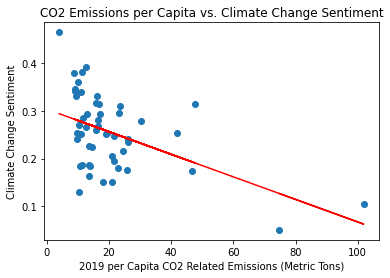

In [987]:
plt.scatter(corr_frame['2019'],corr_frame['sent_index'])
m, b = np.polyfit(corr_frame['2019'], corr_frame['sent_index'], 1)
plt.title("CO2 Emissions per Capita vs. Climate Change Sentiment")
plt.xlabel("2019 per Capita CO2 Related Emissions (Metric Tons)")
plt.ylabel("Climate Change Sentiment")
plt.plot(corr_frame['2019'], m*corr_frame['2019']+b, color='red')

Correlation Coefficient $\approx -0.5$

In [1008]:
state_geo = "us-states.json"
state_data = combined[['state_id',-1,1,'population','sent_index','norm']]

In [1025]:
m = folium.Map(location=[40, -95], zoom_start=4)

In [1027]:
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_data,
    columns=["state_id", "norm"],
    key_on="feature.id",
    fill_color="RdYlGn",
    fill_opacity=0.7,
    line_opacity=.1,
    legend_name="Sentiment",
).add_to(m)

folium.LayerControl().add_to(m)

m

In [1014]:
m.save("map.html")